# Nonlinear Buckling Analysis of the uCRM-9

After the nonlinear buckling analysis on the different box beam configurations and the investigation of their equilibrium paths, we are finally ready to study the nonlinear buckling behavior of the uCRM-9.

* [Setup of the numerical model](#numerical-model)
* [Linear buckling analysis](#linear-buckling)
* [Nonlinear analysis: sensitivity of nonlinear analysis parameters](#nonlinear-analysis-parameters)
    * [Error function](#error-function)
    * [Convergence tolerance](#convergence-tolerance)
    * [Initial load increment](#ninc)
    * [Desired number of iteration](#desiter)
    * [Minimum allowable arc-length adjustment ratio](#minalr)
    * [Maximum allowable arc-length adjustment ratio](#maxalr)
* [Nonlinear analysis: nonlinear buckling method verification](#nonlinear-buckling-method-verification)
* [Conclusions](#conclusions)

## Setup of the numerical model <a name="numerical-model"></a>

***

The uCRM-9 is a flexible version of NASA's Common Research Model (CRM, [Vassberg et al. 2008](https://arc.aiaa.org/doi/abs/10.2514/6.2008-6919)) developed by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603). The structural mesh files for the aluminum wingbox structure including material properties based on a smeared stiffness blade-stiffened panel approach can be found on [this Mendeley Data page](https://data.mendeley.com/datasets/gpk4zn73xn/1). Also the aerodynamic loads for the nominal 1g cruise and the Nastran run files for linear static analysis (SOL 101) and modal analysis (SOL 103) are given in the same place.

To use the uCRM-9 model, we initialize a `BDF` object, create a case control deck requesting displacements and applied loads to be stored in the op2 file, and include the bdf file with the structural mesh of the wingbox in our object. The bdf file contains also the SPC cards defining the single point constraint applied to the model. For this reason, we record the the id of those cards and add it to the case control deck.

In [1]:
from pyNastran.bdf.bdf import BDF
import os

# Initialize BDF object
ucrm9_bdf = BDF(debug=None)  

# Create case control deck
ucrm9_bdf.create_subcases(0)
ucrm9_bdf.case_control_deck.subcases[0].add('ECHO', 'NONE', [], 'STRING-type')  # request no Bulk Data to be printed
ucrm9_bdf.case_control_deck.subcases[0].add_result_type('DISPLACEMENT', 'ALL', ['PLOT'])  # store displacement data of all nodes in the op2 file
ucrm9_bdf.case_control_deck.subcases[0].add_result_type('OLOAD', 'ALL', ['PLOT'])  # store form and type of applied load vector

# Include structural mesh
ucrm9_bdf.add_include_file(os.path.join(os.pardir, os.pardir, 'resources', 'uCRM-9_wingbox_coarse.bdf'))  # structural model of the wingbox
spc_id = 1
ucrm9_bdf.case_control_deck.subcases[0].add_integer_type('SPC', spc_id)

subcase=0 already exists...skipping


Then we add some PARAM cards to replicate the settings prescribed in the original run files.

In [2]:
# Add PARAM cards
ucrm9_bdf.add_param('AUTOSPC', ['NO'])  # singularities in the stiffness matrix will not be constrained
ucrm9_bdf.add_param('GRDPNT', [1])  # execute grid point weight generator using node with id 1 as reference point
ucrm9_bdf.add_param('K6ROT', [1e5])  # specifies the scaling factor of the penalty stiffness to be added to the normal rotation for CQUAD4 and CTRIA3 elements
ucrm9_bdf.add_param('COUPMASS', [-1])  # causes the generation of lumped mass matrices (which may include torsion inertia for beam elements, and some coupling if there are beam offsets) for the following elements: CBAR, CBEAM, CONROD, CQUAD4, CHEXA, CPENTA, CPYRAM, CQUAD8, CROD, CTETRA, CTRIA3, CTRlA6, CTRIAX6, CTUBE
ucrm9_bdf.add_param('MAXRATIO', [1e7])  # threshold for the ratios of terms on the diagonal of the stiffness matrix to the corresponding terms on the diagonal of the triangular factor above which the matrix will be considered to be nearly singular
ucrm9_bdf.add_param('POST', [1])  # store results in a op2 file
ucrm9_bdf.add_param('WTMASS', [1.])  # the terms of the structural mass matrix are multiplied by the value of WTMASS when they are generated

PARAM     WTMASS      1.

In this notebook we want to use the aerodynamic load of the 1g cruise condition and scale it uniformly, with the aim of analyzing the nonlinear behavior of the uCRM-9 under a pseudo-aerodynamic load. For this reason, we include the bdf file with the FORCE cards describing the 1g aerodynamic load in our `BDF` object, and we record the id of those cards.

In [3]:
ucrm9_bdf.add_include_file(os.path.join(os.pardir, os.pardir, 'resources', 'uCRM-9_aero_forces_1.0g_coarse.bdf'))  # aerodynamic 1g load
force_id = 1

## Linear buckling analysis <a name="linear-buckling"></a>

***

 We run a linear buckling analysis with SOL 105 calling the function `run_sol_105_buckling_analysis` from the `pynastran_utils` module. Then we find the critical buckling factor and we plot the associated buckling mode together with the node where the maximum displacement occurs.

Nastran job linear_buckling.bdf completed
Wall time: 17.0 s


Buckling factor: 2.9


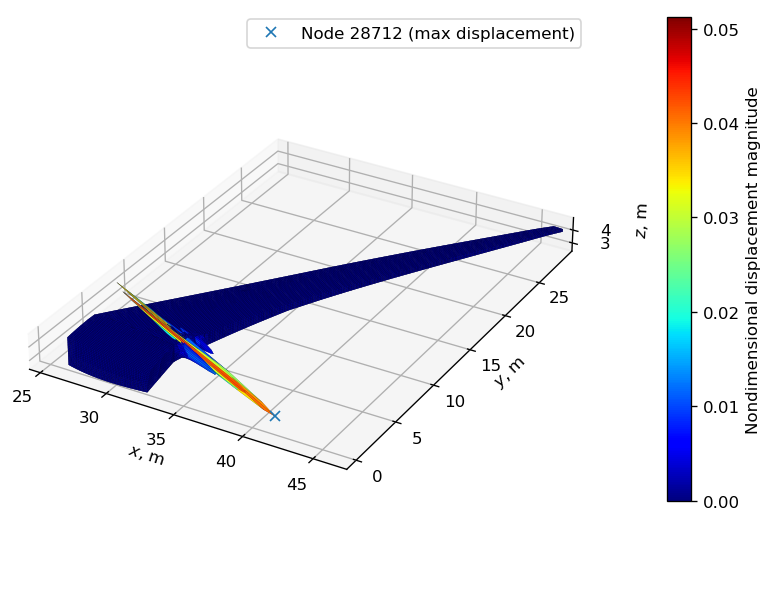

In [4]:
# Uncomment next line to enable the interactive features of matplotlib
# %matplotlib widget

from resources import pynastran_utils
import matplotlib.pyplot as plt
import numpy as np

# Define analysis directory
analysis_directory_name = '17_Nonlinear_Buckling_Analysis_of_the_uCRM-9'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)

# Run analysis
input_name = 'linear_buckling'
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=ucrm9_bdf.__deepcopy__({}), static_load_set_id=force_id,
                                                            analysis_directory_path=analysis_directory_path, input_name=input_name,
                                                            run_flag=False)

# Find critical buckling factor and print it
eigenvalue_calculation_subcase_id = 2
sol_105_buckling_factor = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
print(f'Buckling factor: {sol_105_buckling_factor:.1f}')

# Plot buckling mode
plt.rcParams['figure.dpi'] = 120 # set default dpi of figures
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=eigenvalue_calculation_subcase_id,
                                                 displacement_component='magnitude', colormap='jet', length_unit='m')
ax.locator_params(axis='x', nbins=8)  # set number of ticks of z-axis
ax.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, .84))  # decrease colorbar size
cbar.ax.set_position(cbar.ax.get_position().translated(.05, .15))  # move colorbar upwards

# Find node where max displacement occurs
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].node_gridtype[max_displacement_index, 0]
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz + 200*sol_105_op2.eigenvectors[
    eigenvalue_calculation_subcase_id].data[0, max_displacement_index, 0:3]

# Plot node and show overall plot
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x',
        label=f'Node {max_displacement_node_id:d} (max displacement)', zorder=4)
ax.legend()
plt.show()

## Nonlinear analysis: sensitivity of nonlinear analysis parameters <a name="nonlinear-analysis-parameters"></a>

***

Now we want to investigate the sensitivity of the nonlinear analysis parameters of SOL 106. We set the applied load to twice the critical buckling load predicted by SOL 105. We do this by scaling up the 1g aerodynamic load with the critical buckling factor multiplied by two. Then we set up SOL 106 with the arc-length method.

In [5]:
load_scale_factor = 2  # scale factor of buckling load
load_set_id = force_id + 1  # define id of load set
ucrm9_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[sol_105_buckling_factor*load_scale_factor], load_ids=[force_id])  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(bdf_object=ucrm9_bdf, subcase_id=1, load_set_id=load_set_id)  # create subcase with defined load set
pynastran_utils.set_up_arc_length_method(ucrm9_bdf)  # set up SOL 106 with arc-length method using default parameters

Before moving on to the nonlinear analyses, we need to add an option to change all CQUADR cards into CQUAD4 cards, as SOL 106 cannot work with the former type of elements.

In [6]:
ucrm9_bdf.system_command_lines[0:0] = ['NASTRAN QRMETH=3']

### Error function <a name="error-function"></a>

We start our sensitivity study by looking at the error function. We consider four different combinations of error functions:
- load and energy (default);
- load and displacement with vector component checking;
- load, energy and displacement;
- load, energy and displacement with vector component checking. 

In [7]:
error_functions = ['PW', 'PUV', 'PWU', 'PWUV']

Next we define the function `plot_load_displacement_diagram` to run the Nastran analysis, read the load and displacement history from the op2 file and plot the load-displacement curve on a pre-defined figure. For the displacement we consider the tip displacement $u_{z, tip}$ and nondimensionalize it with the span of the uCRM-9, $b=58.75$ m.

In [8]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles
from pyNastran.op2.op2 import read_op2

tip_node_id = 11847
component_index = 2  # displacement and load along the z-axis
b = 58.76  # uCRM-9 wingspan [m]
markers = list(Line2D.markers.keys())[2:]  # list of marker characters

def plot_load_displacement_curve(bdf_input, filename, axes, marker_style, line_label, run_flag=False):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=filename, run_flag=run_flag)
    # Read load and displacement history from op2 file
    op2_path = os.path.join(analysis_directory_path, filename + '.op2')
    op2 = read_op2(op2_path, debug=None)
    step, _, disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=tip_node_id)
    # Plot load-displacement curve on input axes
    axes.plot(disp[1][:, component_index]/b, step[1]*load_scale_factor, marker=marker_style, linestyle='-', label=line_label)

We run the analyses with the different error functions and plot the results.

Nastran job nonlinear_analysis_error_function_PW.bdf completed
Wall time: 411.0 s


Nastran job nonlinear_analysis_error_function_PUV.bdf completed
Wall time: 410.0 s


Nastran job nonlinear_analysis_error_function_PWU.bdf completed
Wall time: 423.0 s


Nastran job nonlinear_analysis_error_function_PWUV.bdf completed
Wall time: 393.0 s


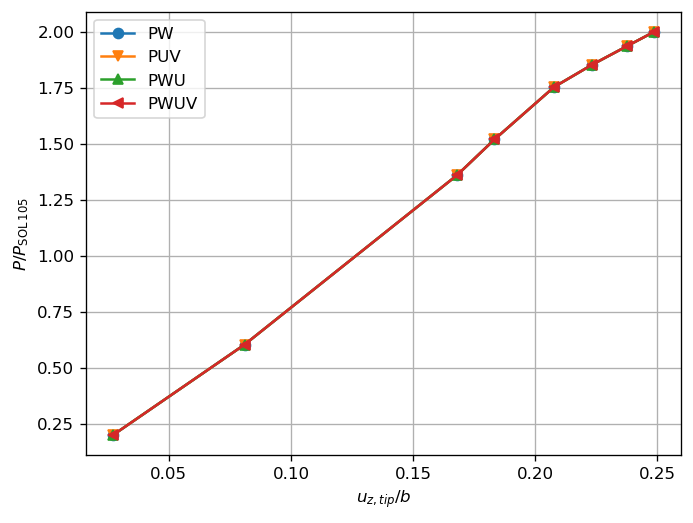

In [9]:
nlparm_id = next(iter(ucrm9_bdf.nlparms))  # retrieve id of NLPARM card
_, ax = plt.subplots()  # create figure with one subplot

# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    ucrm9_bdf.nlparms[nlparm_id].conv = fun
    input_name = 'nonlinear_analysis_error_function_' + fun
    plot_load_displacement_curve(ucrm9_bdf, input_name, ax, markers[count], f'{fun}', run_flag=False)

# Set plot appearance
plt.xlabel('$u_{z, tip}/b$')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

The load-diaplcement diagram appears to be significantly nonlinear, with an initial stiffening response followed by a softening behavior. However, this observation is very preliminary, as the employed arc-length size is very large. As far as the error functions are concerned, they do not seem to affect the results in terms of load-displacement curve. As a consequence, we restore the default parameter.

In [10]:
ucrm9_bdf.nlparms[nlparm_id].conv = 'PW'

### Convergence tolerance <a name="convergence-tolerance"></a>

The second parameter that we consider is the convergence tolerance. Let's take three different combinations of load and energy tolerances, taken from [table 21](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/qrg/bulkno/TOC.NLPARM.xhtml) of MSC Nastran *Quick Reference Guide* manual on the default tolerances for static nonlinear SOL analysis with 106:
- $EPSP=10^{-1}$, $EPSW=10^{-1}$;
- $EPSP=10^{-2}$, $EPSW=10^{-3}$;
- $EPSP=10^{-3}$, $EPSW=10^{-7}$,

where the default values are $EPSP=10^{-2}$ and $EPSW=10^{-2}$.

Let's define the list of convergence tolerances, run the analyses and visualize the results.

Nastran job nonlinear_analysis_load_tolerance_1e-01.bdf completed
Wall time: 922.0 s


Nastran job nonlinear_analysis_load_tolerance_1e-02.bdf completed
Wall time: 373.0 s


Nastran job nonlinear_analysis_load_tolerance_1e-03.bdf completed
Wall time: 455.0 s


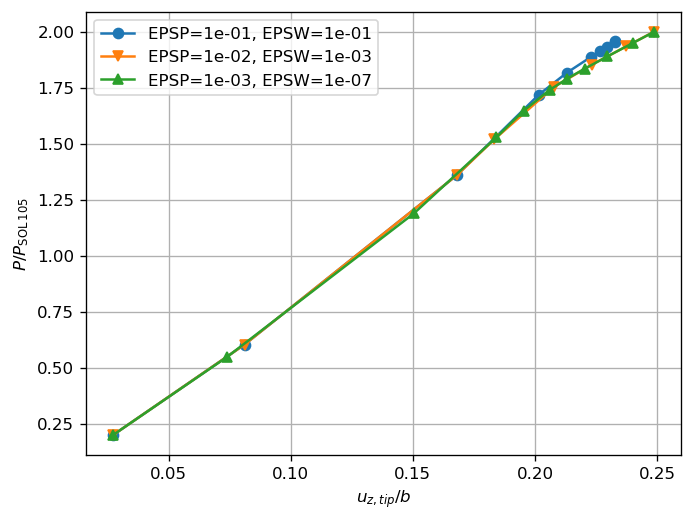

In [11]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]

# Create figure, run analysis for each couple of convergence tolerances and plot load-displacement diagram
_, ax = plt.subplots()
for count, epsp in enumerate(load_tolerances):
    epsw = work_tolerances[count]
    ucrm9_bdf.nlparms[nlparm_id].eps_p = epsp
    ucrm9_bdf.nlparms[nlparm_id].eps_w = epsw
    input_name = f'nonlinear_analysis_load_tolerance_{epsp:.0e}'
    plot_load_displacement_curve(ucrm9_bdf, input_name, ax, markers[count], f'EPSP={epsp:.0e}, EPSW={epsw:.0e}', run_flag=False)

# Set plot appearance
plt.xlabel('$u_{z, tip}/b$')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

The blue points appear to describe a different equilibrium path with respect to the other points. Let's check whether the difference is due to the looser convergence tolerances or if it is actually because the solver has jumped to an equilibrium path different from the natural one.

We define two subcases, similarly to our last notebooks.

1. Aero load, $EPSP=10^{-1}, EPSW=10^{-1}, MAXBIS=10, MINALR=0.01$, default remaining parameters;
2. No load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$, default remaining parameters.

In the first subcase we increase the maximum number of bisections for each load increment and the minimum arc-length adjustment ratio because the previous analysis failed to achieve convergence close to $P/P_\text{SOL 105}=2$, as it can be observed in the plot above, and the f06 file indicated that one of the two parameters was violated. In the second subcase we use $\Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$ to obtain a very fine resolution of the equilibrium path while unloading the structure.

In [12]:
# Modify first subcase
loading_subcase_id = 1
ucrm9_bdf.nlparms[loading_subcase_id].eps_p = 1e-1  # load tolerance
ucrm9_bdf.nlparms[loading_subcase_id].eps_w = 1e-1  # work tolerance
ucrm9_bdf.nlparms[loading_subcase_id].max_bisect = 10  # maximum number of bisections
ucrm9_bdf.nlpcis[loading_subcase_id].minalr = .01  # minimum arc-length ratio

# Create second subcase
zero_load_set_id = load_set_id + 1  # id of LOAD card
ucrm9_bdf.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[force_id])  # add LOAD card with zero applied load
unloading_subcase_id = 2
pynastran_utils.create_static_load_subcase(bdf_object=ucrm9_bdf, subcase_id=unloading_subcase_id, load_set_id=zero_load_set_id)  # create subcase with zero applied load
pynastran_utils.set_up_arc_length_method(bdf_object=ucrm9_bdf, nlparm_id=unloading_subcase_id, eps_p=1e-3, eps_w=1e-7, ninc=100,
                                         desiter=5, maxalr=1.01, maxinc=100, subcase_id=unloading_subcase_id)  # set up arc-length method for second subcase using parameters for very fine resolution of equilibrium path

Let's run the analysis tracking the 10 lowest eigenvalues of the tangent stiffness matrix. For this we call the function `run_tangent_stiffness_matrix_eigenvalue_calculation` from the `pynastran_utils` module.

In [13]:
method_set_id = zero_load_set_id + 1
no_eigenvalues = 10
analysis_label = "epsp1e-1"
input_name = "path_existence_verification_" + analysis_label
sol_106_op2 = {}
sol_106_op2[analysis_label] = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=ucrm9_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)

Nastran job path_existence_verification_epsp1e-1.bdf completed
Wall time: 6309.0 s


Now we want to plot the load-displacement diagram and the eigenvalues of the tangent stiffness matrix. For this reason, we define the functions `plot_load_displacement_diagram` and `plot_tangent_stiffness_matrix_eigenvalues`. We use the first to plot the applied load against the nondimensional tip displacement, $u_{z, tip}/b$, and the second to plot the eigenvalues of the tangent stiffness matrix $\lambda$ against the iteration number and the applied load.

In [14]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # retrieve list with succession of standard matplotlib colors

# Find overall critical buckling load magnitude - needed to nondimensionalize the applied load
applied_load_magnitude = np.linalg.norm(np.apply_along_axis(np.sum, 1, sol_105_op2.load_vectors[1].data[:, :, 0:3]))
sol_105_buckling_load_magnitude = applied_load_magnitude*sol_105_buckling_factor

# Define function to plot load-displacement diagram
def plot_load_displacement_diagram(disp, loads):
    # Create figure with one subplot
    _, load_displacement_ax = plt.subplots()
    # Plot nondimensional applied load vs nondimensional tip displacement for each subcase
    for subcase_id in disp:
        load_displacement_ax.plot(disp[subcase_id][:, component_index]/b, np.apply_along_axis(
            np.linalg.norm, 1, loads[subcase_id])/sol_105_buckling_load_magnitude, marker=markers[subcase_id - 1],
            label=f'Subcase {subcase_id:d}')
    # Set plot appearance
    load_displacement_ax.legend()  # set up legend
    plt.xlabel('$u_{z, tip}/b$')
    plt.ylabel('$P/P_\mathrm{SOL\/105}$')
    plt.grid()
    plt.show()

# Define function to plot the eigenvalue diagram
def plot_tangent_stiffness_matrix_eigenvalues(directory_path, input_name, loads):
    # Read eigenvalues from f06 file
    f06_path = os.path.join(directory_path, input_name + '.f06')  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Create figure with 2 subplots
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey='all')
    # Discern lowest eigenvalues by subcase and plot them
    iterations_count = 1
    eigenvalues_count = 0
    eigenvalues_by_subcase = {}
    for subcase_id in loads:  # iterate over subcases
        no_load_steps = len(loads[subcase_id])  # find number of load steps in current subcase
        eigenvalues_by_subcase[subcase_id] = eigvals[:, eigenvalues_count:eigenvalues_count + no_load_steps]  # find eigenvalues of current subcase
        eigenvalues_count += no_load_steps  # update count of eigenvalues sorted so far
        # Plot eigenvalues vs iteration number in first subplot
        eigvals_axs[0].plot(np.arange(iterations_count, eigenvalues_by_subcase[subcase_id].shape[1] + iterations_count),
                            eigenvalues_by_subcase[subcase_id].T, markers[subcase_id - 1], color=colors[subcase_id - 1],
                            label=f'Subcase {subcase_id:d}')
        no_iterations_subcase = eigenvalues_by_subcase[subcase_id].shape[1]  # save number of converged iterations in current subcase
        iterations_count += no_iterations_subcase  # update iterations count by adding the number of iterations of current subcase
        # Plot eigenvalues vs applied load in second subplot
        eigvals_axs[1].plot(np.apply_along_axis(np.linalg.norm, 1, loads[subcase_id][0:no_iterations_subcase, :])/sol_105_buckling_load_magnitude,
                            eigenvalues_by_subcase[subcase_id].T, markers[subcase_id - 1], color=colors[subcase_id - 1])
    # Set plot appearance
    eigvals_axs[0].set_xlabel('Iteration')
    eigvals_axs[0].set_ylabel('$\lambda$, N/m')
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
    eigvals_axs[1].grid(visible=True)
    plt.show()

Let's call the defined functions and plot our results now.

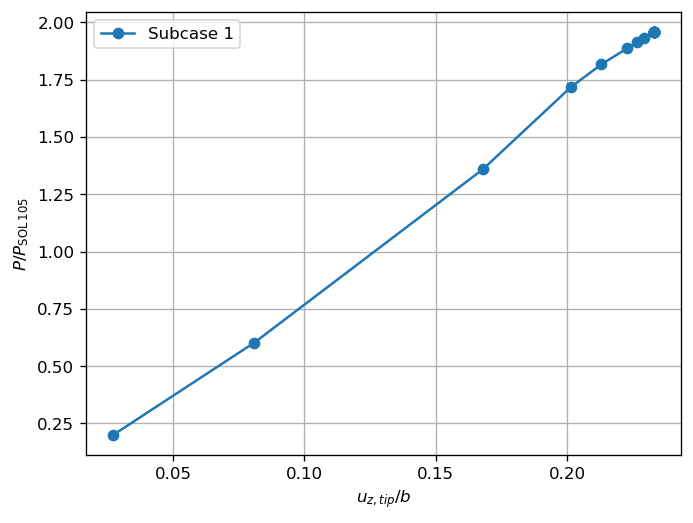

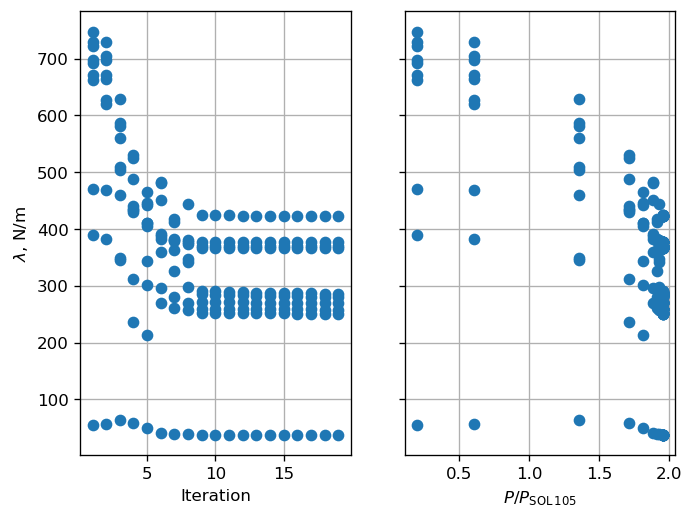

In [15]:
applied_loads = {}
tip_displacements = {}
_, applied_loads[analysis_label], tip_displacements[analysis_label] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[analysis_label], displacement_node_id=tip_node_id)
plot_load_displacement_diagram(tip_displacements[analysis_label], applied_loads[analysis_label])
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads[analysis_label])

Despite the increased number of allowed bisections for each load increment and the reduced minimum arc-length adjustment ratio, the first subcase still fails to converge close to $P/P_\text{SOL 105}=2$. This time, the f06 file indicates that the analysis reached the maximum number of increment per subcase (20). Looking at the eigenvalue diagram we can observe that the last load increments are very small and that the eigenvalues are always positive. This suggests that the solver has not jumped from the natural path to a complementary path, and that the failed convergence is most probably caused by the very loose convergence tolerances, which are responsible for a poor accuracy of the nonlinear solution.

We run an analysis with the following subcases to verify that curves obtained with the tighter convergence tolerances actually describe the natural equilibrium path of the uCRM-9 under the pseudo-aerodynamic load.

1. Aero load, $EPSP=10^{-2}, EPSW=10^{-3}$, same remaining parameters as previous analysis.
2. No load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$, same remaining parameters as previous analysis.

Nastran job path_existence_verification_epsp1e-2.bdf completed
Wall time: 1702.0 s


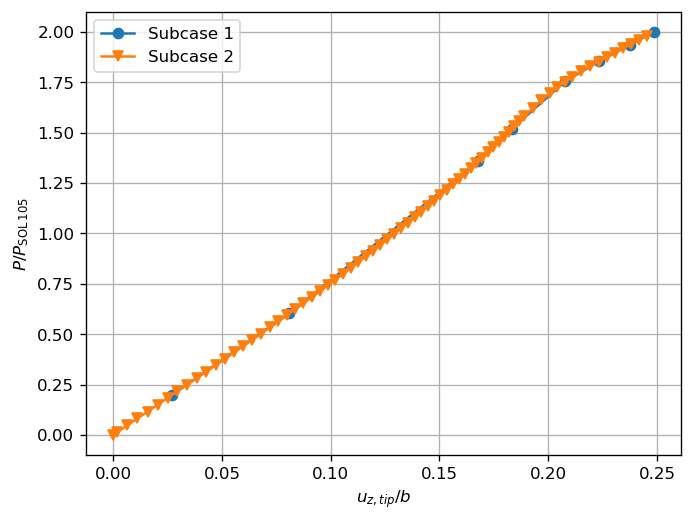

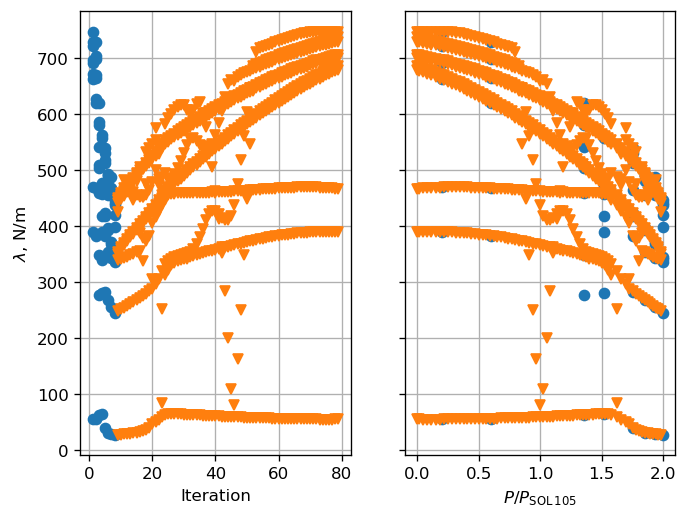

In [16]:
# Modify first subcase
ucrm9_bdf.nlparms[loading_subcase_id].eps_p = 1e-2  # load tolerance
ucrm9_bdf.nlparms[loading_subcase_id].eps_w = 1e-3  # work tolerance

# Run analysis
analysis_label = "epsp1e-2"
input_name = "path_existence_verification_" + analysis_label
sol_106_op2[analysis_label] = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=ucrm9_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)

# Plot results
_, applied_loads[analysis_label], tip_displacements[analysis_label] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[analysis_label], displacement_node_id=tip_node_id)
plot_load_displacement_diagram(tip_displacements[analysis_label], applied_loads[analysis_label])
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads[analysis_label])

The results suggest that indeed the curves obtained with tighter convergence tolerances describe the natural equilibrium path. It is interesting to notice the sharp drop and rise of some eigenvalues, which is most probably related to sudden changes of the deformation shape of the uCRM-9. For this reason, we inspect the deformation of the wingbox at the end of the first subcase. Since the vertical displacement of the tip is very large with respect to potential local out-of-plane displacements over the wingbox, we look at the elements' rotation $\theta$ along $x$, $y$ and $z$.

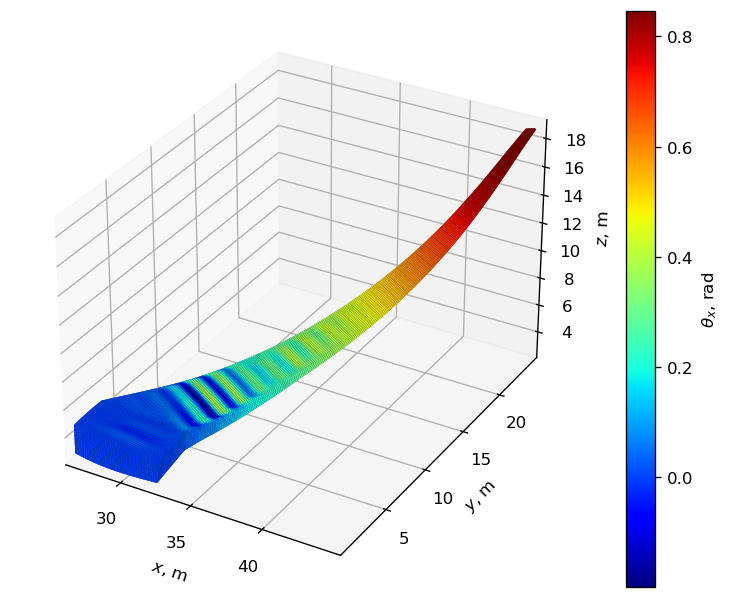

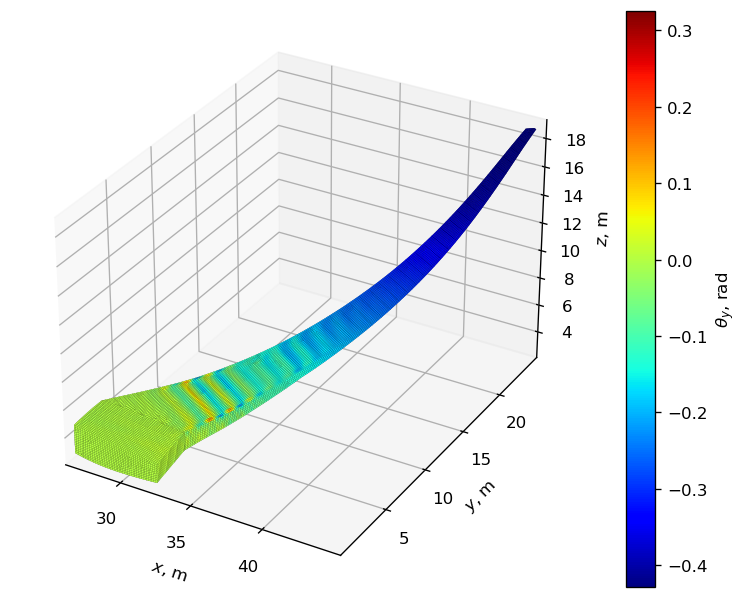

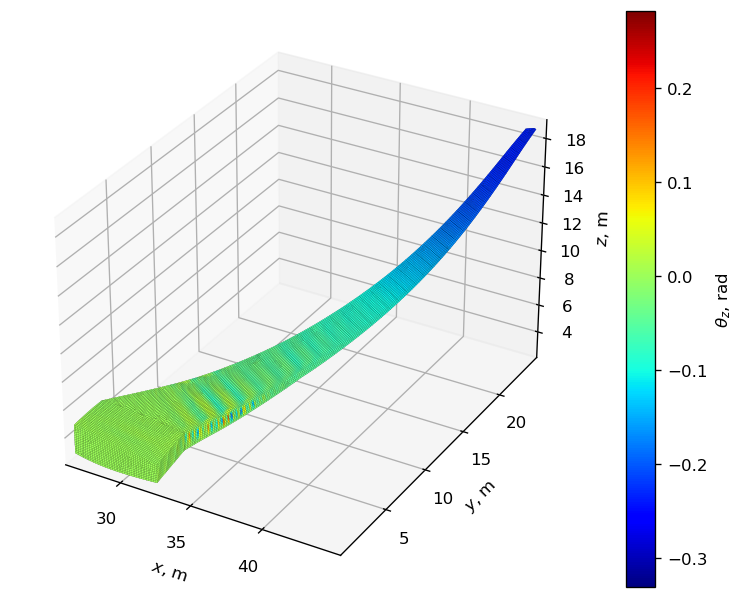

In [17]:
for component in ['rx', 'ry', 'rz']:
    _, ax, _ = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2[analysis_label], displacement_component=component,
                                                       length_unit='m')
    ax.locator_params(axis='x', nbins=7)  # set number of ticks of z-axis

We observe that the deformation state of the uCRM-9 is characterized by a buckling-like shape over the inboard part of the top skin and the two spars (and over the rear spar more strongly than the front one). The severity of this buckled shape decreases towards the outboard section of the wingbox, where the deformation shape is more global and does not have any local feature.

We leave the convergence tolerances as $EPSP=10^{-2}, EPSW=10^{-3}$ and move on to the next nonlinear analysis parameter.

### Initial load increment <a name="initial-load-increment"></a>

We consider three different values of initial load increment:
- $\Delta\mu^1=0.5$;
- $\Delta\mu^1=0.1$ (default);
- $\Delta\mu^1=0.01$.

In [18]:
initial_load_increments = [.5, .1, .01]  # define list of initial load increments

We remove the second subcase, run the analyses and plot the results.

Nastran job nonlinear_analysis_initial_load_increment_0_50.bdf completed
Wall time: 466.0 s


Nastran job nonlinear_analysis_initial_load_increment_0_10.bdf completed
Wall time: 359.0 s


Nastran job nonlinear_analysis_initial_load_increment_0_01.bdf completed
Wall time: 460.0 s


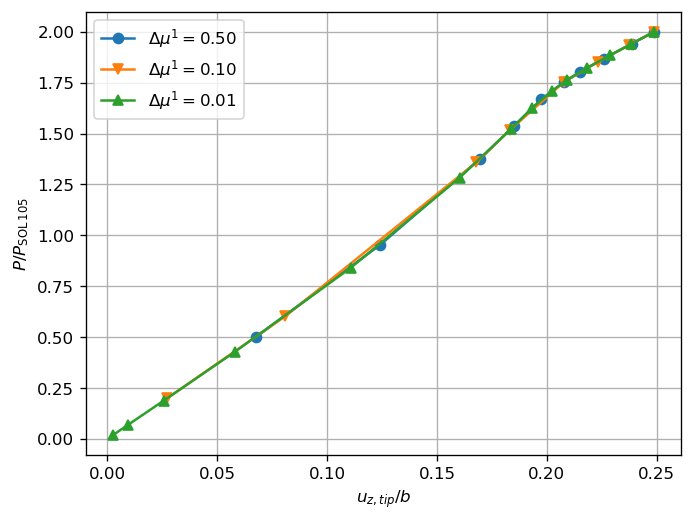

In [19]:
# Remove second subcase
del ucrm9_bdf.subcases[unloading_subcase_id]

# Create figure, run analysis for each initial load increment and plot load-displacement diagram
_, ax = plt.subplots()
for count, delta_mu_1 in enumerate(initial_load_increments):
    ucrm9_bdf.nlparms[loading_subcase_id].ninc = round(1/delta_mu_1)
    input_filename = f'nonlinear_analysis_initial_load_increment_{delta_mu_1:.2f}'.replace('.','_')
    plot_load_displacement_curve(ucrm9_bdf, input_filename, ax, markers[count], f'$\Delta\mu^1={delta_mu_1:.2f}$', run_flag=False)

# Set plot appearance
plt.xlabel('$u_{z, tip}/b$')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

These results appear to describe the same load-displacement curves, corresponding to the natural equilibrium path. As a consequence, we conclude that the initial load increment does not have any effect from this point of view. We select $\Delta\mu^1=0.1$ as it was the value resulting in the shortest computation time, and we move on to the next parameter.

In [20]:
ucrm9_bdf.nlparms[loading_subcase_id].ninc = 10

### Desired number of iterations <a name="desiter"></a>

Now we investigate the influence of the desired number of iterations, using the following values:

- $DESITER=20$;
- $DESITER=12$ (default);
- $DESITER=5$.

Nastran job nonlinear_analysis_desiter_20.bdf completed
Wall time: 331.0 s


Nastran job nonlinear_analysis_desiter_12.bdf completed
Wall time: 371.0 s


Nastran job nonlinear_analysis_desiter_5.bdf completed
Wall time: 1154.0 s


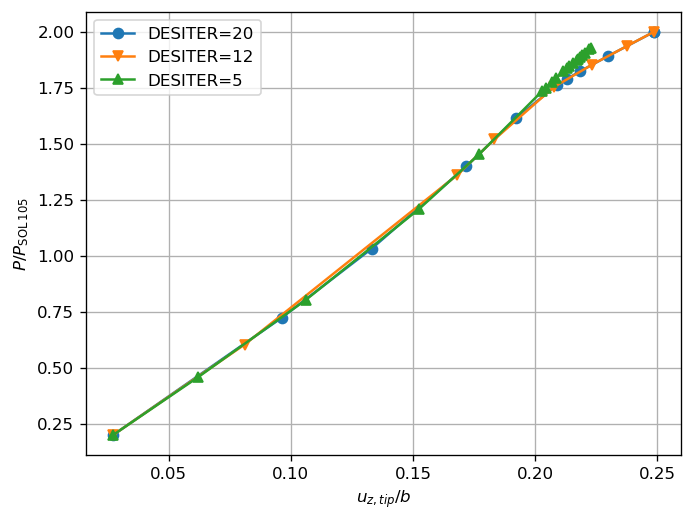

In [21]:
no_desired_iterations = [20, 12, 5]  # define list of desired numbers of iterations

# Create figure, run analysis for each desired number of iterations, plot load-displacement diagram
_, ax = plt.subplots()
for count, desiter in enumerate(no_desired_iterations):
    ucrm9_bdf.nlpcis[loading_subcase_id].desiter = desiter
    input_filename = 'nonlinear_analysis_desiter_' + str(desiter)
    plot_load_displacement_curve(ucrm9_bdf, input_filename, ax, markers[count], f'DESITER={desiter}', run_flag=False)

# Set plot appearance
plt.xlabel('$u_{z, tip}/b$')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

The curve obtained for $DESITER=5$ appears to describe a different equilibrium path with respect to the natural one. We investigate this by running a new analysis with two subcases:

1. aero load, $EPSP=10^{-2}, EPSW=10^{-3}, DESITER=5, MAXBIS=10, MINALR=0.01, MXINC=40$, remaining default parameters;
2. no load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01, MXINC=200$, remaining default parameters.

In the first subcase we keep the values for $MAXBIS$ and $MINALR$ set previously, and we increase the maximum number of allowed increments to $MXINC=40$. We modify the latter because the last analysis failed to achieve convergence close to $P/P_\text{SOL 105}=2$, and the f06 file indicated that the maximum number of allowed increments was violated. In the second subcase we use $\Delta\mu^1=0.01, DESITER=5, MAXALR=1.01, MXINC=200$ to obtain a very fine resolution of the equilibrium path while unloading the structure.

Nastran job path_existence_verification_desiter5.bdf completed
Wall time: 6637.0 s


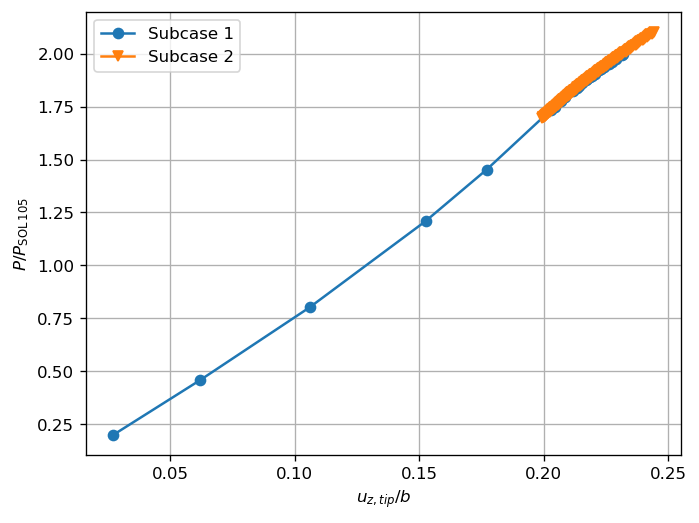

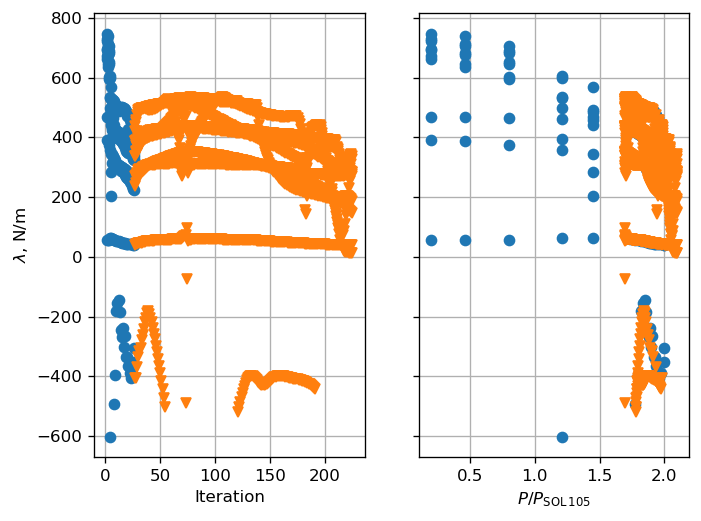

In [22]:
# Increase maximum number of allowed increments for first subcase
ucrm9_bdf.nlpcis[loading_subcase_id].mxinc = 40
ucrm9_bdf.nlpcis[unloading_subcase_id].mxinc = 200

# Create second subcase
pynastran_utils.create_static_load_subcase(bdf_object=ucrm9_bdf, subcase_id=unloading_subcase_id, load_set_id=zero_load_set_id)  # create subcase with zero applied load
ucrm9_bdf.case_control_deck.subcases[unloading_subcase_id].add_integer_type("NLPARM", unloading_subcase_id)  # add NLPARM id to case control deck

# Run analysis
analysis_label = "desiter5"
input_name = "path_existence_verification_" + analysis_label
sol_106_op2[analysis_label] = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=ucrm9_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)

# Plot results
_, applied_loads[analysis_label], tip_displacements[analysis_label] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[analysis_label], displacement_node_id=tip_node_id)
plot_load_displacement_diagram(tip_displacements[analysis_label], applied_loads[analysis_label])
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads[analysis_label])

These results show that in the first subcase the solver jumps on an unstable equilibrium path and in the second subcase it follows such path and fails to completely unload the structure. In fact, the solver reaches a minimum load level at approximately $P/P_\text{SOL 105}=1.7$ and then increases the applied load again.

We observe that in the second subcase we miss some negative eigenvalues over a certain interval of iterations. This is due to the fact that the negative eigenvalues become larger in magnitude and the Lanczos algorithm detects another positive eigenvalue within the smallest 10 roots that it is requested to extract. To visualize the full trend of the negative eigenvalues we would need to rerun the analysis requesting the calculation of more eigenvalues. However, for the sake of our study this is not necessary, as the behavior of the uCRM-9 along the unstable path is already evident from the last analysis.

Similarly to our previous notebooks, we want to visualize a 3D load-displacement diagram by plotting together applied load, tip displacement and a local displacement in order to verify whether the observed unstable path is disconnected from the natural one. In our previous studies we used the displacement $u_z$ of the node where we observed the maximum displacement in the linear buckling analysis as a representation of the local displacement. We did this because the greater displacement component of the buckling mode was the one along the $z$ axis. Here the critical buckling mode predicted by SOL 105 involves the deformation of the rear spar, which occurs mainly along the $x$ axis, so instead of the displacement $u_z$, we choose to monitor the displacement $u_x$.

Consequently, we read the displacement history at node 28712 (see the [linear buckling results](#linear-buckling)) from the analyses of interest. Then we convert the local displacements into millimiters, we nondimensionalize the tip displacements with the span of the uCRM-9, and we nondimensionalize the applied loads with the buckling load magnitude predicted by SOL 105.


In [23]:
# Read local displacements
analysis_labels = ["epsp1e-2", "desiter5"]
local_displacements = {}
for analysis_label in analysis_labels:
    _, _, local_displacements[analysis_label] = pynastran_utils.read_load_displacement_history_from_op2(
        op2_object=sol_106_op2[analysis_label], displacement_node_id=max_displacement_node_id)
    
# Create new dictionaries with nondimensionalized quantities
z_component_index = 2
x_component_index = 0
local_displacements_mm = {count: local_displacements[key][unloading_subcase_id][:, x_component_index]*1e3
                          for count, key in enumerate(analysis_labels)}
nondimensional_tip_displacements = {count: tip_displacements[key][unloading_subcase_id][:, z_component_index]/b
                                    for count, key in enumerate(analysis_labels)}
nondimensional_applied_loads = {count: np.linalg.norm(applied_loads[key][unloading_subcase_id], axis=1)/sol_105_buckling_load_magnitude
                                for count, key in enumerate(analysis_labels)}

Now we plot our 3D load-displacement diagram.

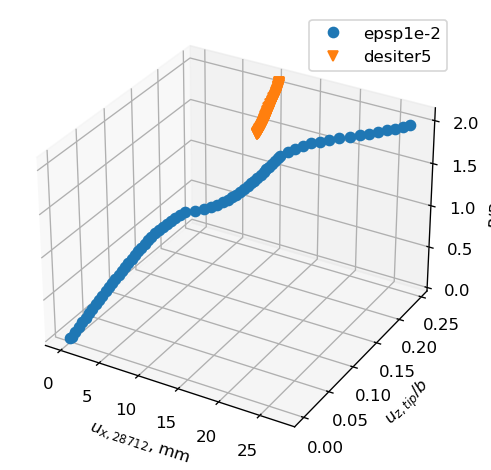

In [24]:
# Create 3D plot of equilibrium diagram
plt.figure()
ax_3d = plt.axes(projection="3d")
for count, key in enumerate(analysis_labels):
    ax_3d.plot3D(local_displacements_mm[count], nondimensional_tip_displacements[count], nondimensional_applied_loads[count],
                 markers[count], color=colors[count], label=key)

# Set plot appearance
ax_3d.set_xlabel(f"$u_{{x, {max_displacement_node_id:d}}}$, mm")
ax_3d.set_ylabel("$u_{z, tip}/b$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
ax_3d.legend()
plt.show()

We observe a clear separation between the blue curve, corresponding to the natural path, and the orange curve, corresponding to a complementary path. As in our previous studies, the curve representing the complementary path is formed by two parts, one corresponding to the unloading of the structure down to the minimum load level of the path, and the other corresponding to the loading of the structure after such minimum load level is reached. However, this time the two parts seem to coincide at a first sight. Only zooming into the plot it is possible to observe a small difference between the two parts. This suggests that the displacement field associated to points at the same load level will be very similar between.

We then investigate the deformation associated to the different equilibrium paths by cutting the load-dispacement diagram with a plane at $P/P_\text{SOL 105}=1.9$ and by plotting the structural deformation at the intersection points.

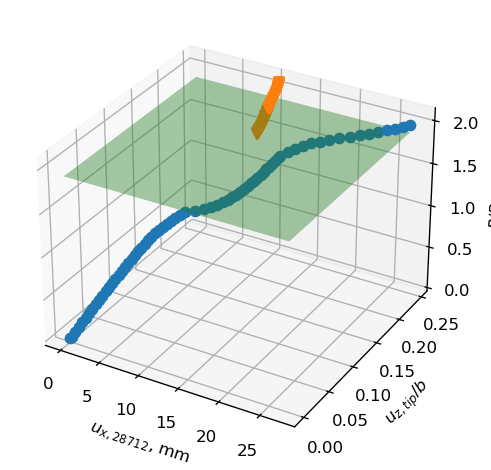

Deformation on natural path:


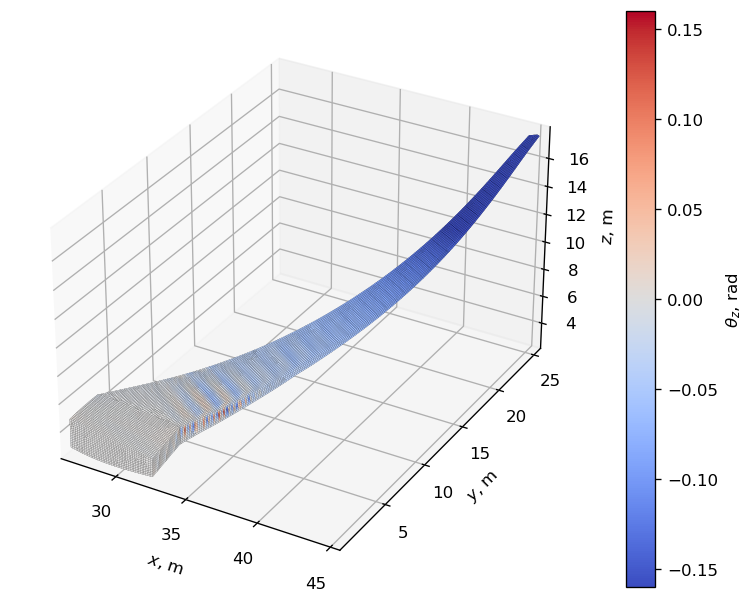

Deformations on unstable path:


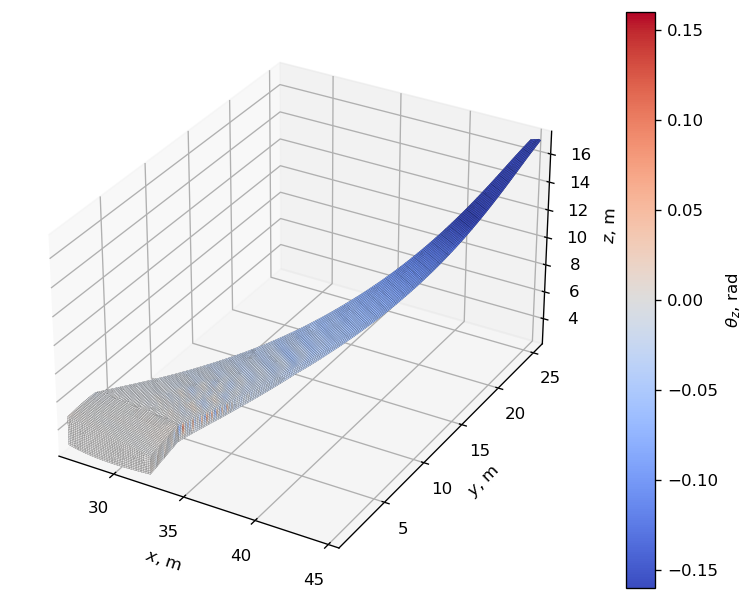

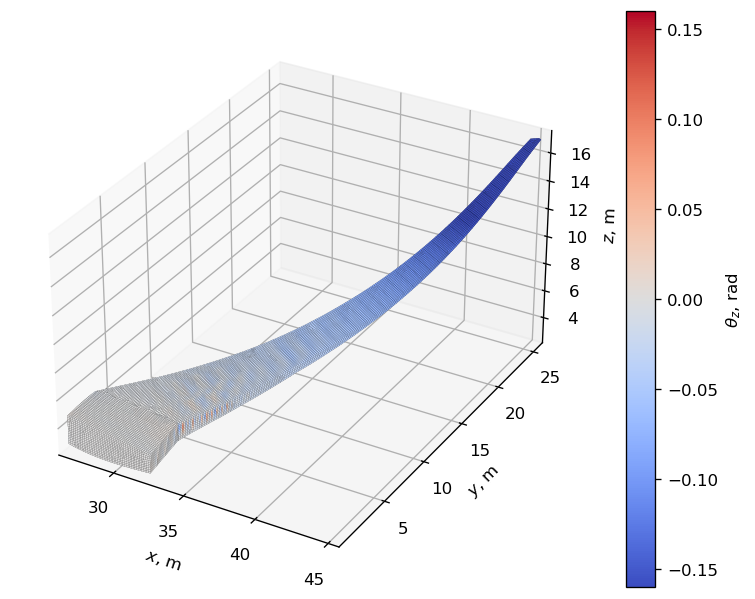

In [25]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection="3d")

# Plot part of the equilibrium paths that should not be visible on top of the plane
load_factor = 1.9
for key in local_displacements_mm:
    ax_3d.plot3D(local_displacements_mm[key], nondimensional_tip_displacements[key],
                 np.where(nondimensional_applied_loads[key]<load_factor, nondimensional_applied_loads[key], np.nan),
                 markers[key], color=colors[key])

# Plot plane
local_displacements_array = np.concatenate(tuple(local_displacements_mm[key] for key in local_displacements_mm))
tip_displacements_array = np.concatenate(tuple(nondimensional_tip_displacements[key] for key in nondimensional_tip_displacements))
xx, yy = np.meshgrid([np.min(local_displacements_array), np.max(local_displacements_array)], [np.min(tip_displacements_array),
                                                                                              np.max(tip_displacements_array)])
ax_3d.plot_surface(xx, yy, np.full_like(xx, load_factor), alpha=0.4, color=colors[len(local_displacements_mm)])

# Plot part of the equilibrium paths that should be visible on top of the plane
for key in local_displacements_mm:
    ax_3d.plot3D(local_displacements_mm[key], nondimensional_tip_displacements[key],
                 np.where(nondimensional_applied_loads[key]>=load_factor, nondimensional_applied_loads[key], np.nan),
                 markers[key], color=colors[key], zorder=3)

# Set plot appearance
ax_3d.set_xlabel(f"$u_{{x, {max_displacement_node_id:d}}}$, mm")
ax_3d.set_ylabel("$u_{z, tip}/b$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
plt.show()

# Plot static deformation of natural path
print("Deformation on natural path:")
key = 0
analysis_label = "epsp1e-2"
load_step = np.argmin(np.abs(nondimensional_applied_loads[key] - load_factor)) + 1  # find closest load step to plane
clim = [-.16, .16]  # set common colorbar values limits to facilitate the comparison among the plots
_, ax, _ = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2[analysis_label], subcase_id=unloading_subcase_id,
                                                   load_step=load_step, displacement_component="rz", colormap="coolwarm", clim=clim,
                                                   length_unit="m")
ax.locator_params(axis='x', nbins=7)  # set number of ticks of z-axis
plt.show()

# Plot first deformation on unstable path
print("Deformations on unstable path:")
key = 1
analysis_label = "desiter5"
min_load_index = np.argmin(nondimensional_applied_loads[key])
load_step = np.argmin(np.abs(nondimensional_applied_loads[key][:min_load_index] - load_factor)) + 1  # find closest load step to plane on first side of the path
_, ax, _ = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2[analysis_label], subcase_id=unloading_subcase_id,
                                                   load_step=load_step, displacement_component="rz", colormap="coolwarm", clim=clim,
                                                   length_unit="m")
ax.locator_params(axis='x', nbins=7)  # set number of ticks of z-axis
plt.show()

# Plot second deformation on unstable path
load_step = np.argmin(np.abs(nondimensional_applied_loads[key][min_load_index:] - load_factor)) + min_load_index + 1  # find closest load step to plane on second side of the path
_, ax, _ = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2[analysis_label], subcase_id=unloading_subcase_id,
                                                   load_step=load_step, displacement_component="rz", colormap="coolwarm", clim=clim,
                                                   length_unit="m")
ax.locator_params(axis='x', nbins=7)  # set number of ticks of z-axis
plt.show()

As expected, we observe a clear difference between the structural deformation on the natural path and the ones on the complementary path, while the deformations corresponding to the two points of the complementary path look identical.

We set the desired number of iterations of the first subcase to 20 (as it resulted in the smallest computational time), delete the second subcase, and continue our investigation moving to the next nonlinear analysis parameter.

In [26]:
ucrm9_bdf.nlpcis[loading_subcase_id].desiter = 20
del ucrm9_bdf.subcases[unloading_subcase_id]

### Minimum allowable arc-length adjustment ratio <a name="minalr"></a>

We assess the effect of the minimum allowable arc-length adjustment ratio, investigating three values:
- $MINALR=0.9$;
- $MINALR=0.25$ (default);
- $MINALR=0.01$.

Nastran job nonlinear_analysis_minalr_0_90.bdf completed
Wall time: 324.0 s


Nastran job nonlinear_analysis_minalr_0_25.bdf completed
Wall time: 321.0 s


Nastran job nonlinear_analysis_minalr_0_01.bdf completed
Wall time: 320.0 s


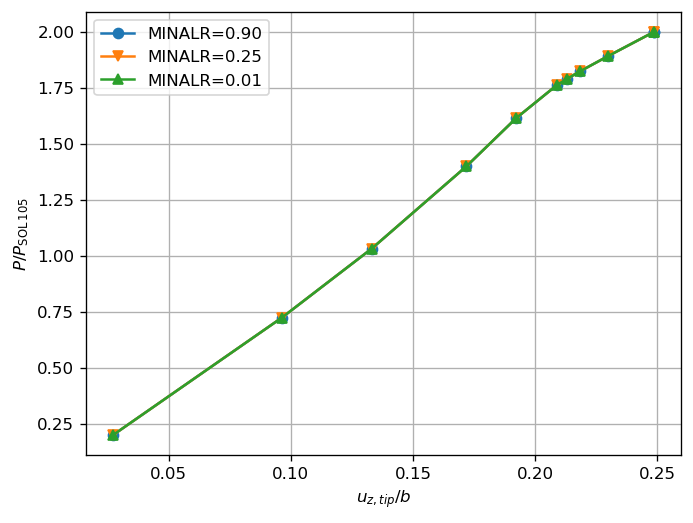

In [27]:
min_arclength_adjustment_ratios = [.9, .25, .01]  # define list of minimum allowable arc-length adjustment ratios

# Create figure, run analysis for each minimum allowable arc-length adjustment ratio and plot load-displacement diagram
_, ax = plt.subplots()
for count, minalr in enumerate(min_arclength_adjustment_ratios):
    ucrm9_bdf.nlpcis[loading_subcase_id].minalr = minalr
    input_filename = f'nonlinear_analysis_minalr_{minalr:.2f}'.replace('.','_')
    plot_load_displacement_curve(ucrm9_bdf, input_filename, ax, markers[count], f'MINALR={minalr:.2f}', run_flag=False)

# Set plot appearance
plt.xlabel('$u_{z, tip}/b$')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

The minimum arc-length adjustment ratio does not have any effect on the results, as the exact same equilibrium points are calculated for all curves. Consequently, we restore the default value and we move on to the next parameter.

In [28]:
ucrm9_bdf.nlpcis[loading_subcase_id].minalr = .25

### Maximum allowable arc-length adjustment ratio <a name="maxalr"></a>

The last parameter that we examine is the maximum allowable arc-length adjustment ratio and we consider three values:
- $MAXALR=10$;
- $MAXALR=4$ (default);
- $MAXALR=1.1$.

Nastran job nonlinear_analysis_maxalr_10_0.bdf completed
Wall time: 331.0 s


Nastran job nonlinear_analysis_maxalr_4_0.bdf completed
Wall time: 323.0 s


Nastran job nonlinear_analysis_maxalr_1_1.bdf completed
Wall time: 273.0 s


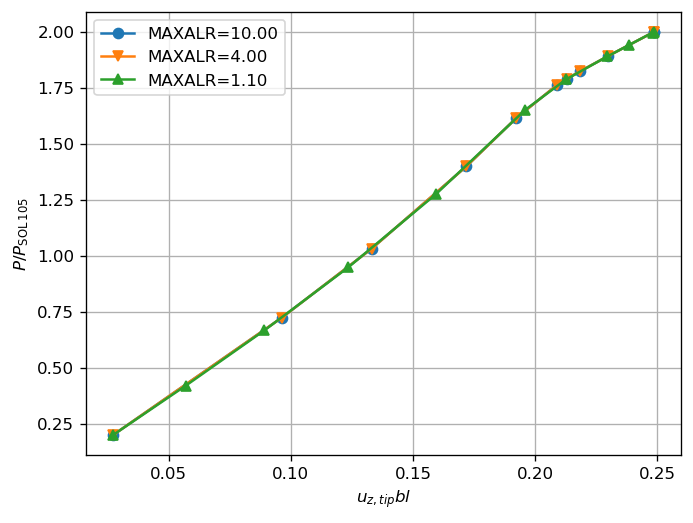

In [29]:
max_arclength_adjustment_ratios = [10., 4., 1.1]  # define list of maximum allowable arc-length adjustment ratios

# Create figure, run analysis for each maximum allowable arc-length adjustment ratio and plot load-displacement diagram
_, ax = plt.subplots()
for count, maxalr in enumerate(max_arclength_adjustment_ratios):
    ucrm9_bdf.nlpcis[loading_subcase_id].maxalr = maxalr
    input_filename = f'nonlinear_analysis_maxalr_{maxalr:.1f}'.replace('.','_')
    plot_load_displacement_curve(ucrm9_bdf, input_filename, ax, markers[count], f'MAXALR={maxalr:.2f}', run_flag=False)

# Set plot appearance
plt.xlabel('$u_{z, tip}bl$')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

The different curves obtained appear to describe the same equilibrium path, so the maximum arc-length adjustment ratio does not have any effect in this regard. The only observable effect in this case is the fact that a lower maximum arc-length adjustment ratio leads to a finer resolution of the load-displacement curve, as expected.

We keep the value that resulted in the lowest computational time, so $MAXALR=1.1$, and we move to the next investigation.

## Nonlinear analysis: nonlinear buckling method verification <a name="nonlinear-buckling-method-verification"></a>

***

Now we are going to verify the results of SOL 106's nonlinear buckling method on the uCRM-9. This means that we are going to assess whether the nonlinear buckling method is able to predict the same critical load as SOL 105 for the initial linear range of the structural response. Besides,we are also going to investigate how the results change in the nonlinear range.

Similarly to what we did in our previous notebooks, we define 11 load magnitudes equally spaced between 0 and twice the linear buckling load. We discard the load case with null magnitude, we keep the other 10 load cases and define the corresponding subcases.

In [30]:
# Define and print the sequence of increasing applied loads
applied_load_factors = np.linspace(0, load_scale_factor, 11)[1:]
np.set_printoptions(precision=1, suppress=True)
print(f'Applied loads factors (P/P_SOL 105): {applied_load_factors}')

# Create new LOAD card with first applied load magnitude and assign card to first subcase
load_set_id = zero_load_set_id + 1
ucrm9_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[sol_105_buckling_factor*applied_load_factors[0]], load_ids=[force_id])
ucrm9_bdf.subcases[1].params["LOAD"][0] = load_set_id

# Create LOAD card and corresponding subcases for remaining applied loads
for i, scale_factor in enumerate(applied_load_factors[1:], start=2):
    load_set_id = load_set_id + 1
    ucrm9_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[sol_105_buckling_factor*scale_factor], load_ids=[force_id])
    pynastran_utils.create_static_load_subcase(bdf_object=ucrm9_bdf, subcase_id=i, load_set_id=load_set_id)

Applied loads factors (P/P_SOL 105): [0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]


Before running our analysis we modify the convergence tolerances for the load and energy function, because initial tests resulted in a failed convergence of the eigenvalue extraction for the last subcase for the set of nonlinear analysis parameters selected in the previous section. This was solved by setting tighter convergence tolerances and the root cause of the failed convergence was not investigated further.

In [31]:
ucrm9_bdf.nlparms[nlparm_id].eps_p = 1e-3  # load tolerance
ucrm9_bdf.nlparms[nlparm_id].eps_w = 1e-7  # work tolerance

We run the analysis employing SOL 106's nonlinear buckling method by calling the function `run_nonlinear_buckling_method` from the `pynastran_utils` module, which takes care of adding the parameters needed to apply the nonlinear buckling method and executes Nastran.

In [32]:
method_set_id = load_set_id + 1
input_name = "nonlinear_buckling_method_verification"
sol_106_op2 = pynastran_utils.run_nonlinear_buckling_method(bdf_object=ucrm9_bdf, method_set_id=method_set_id,
                                                            analysis_directory_path=analysis_directory_path, input_name=input_name,
                                                            run_flag=False)

Nastran job nonlinear_buckling_method_verification.bdf completed
Wall time: 934.0 s


Finally we plot our results in terms of buckling load predicted by SOL 106 and critical buckling factor $\alpha$ against the applied load.

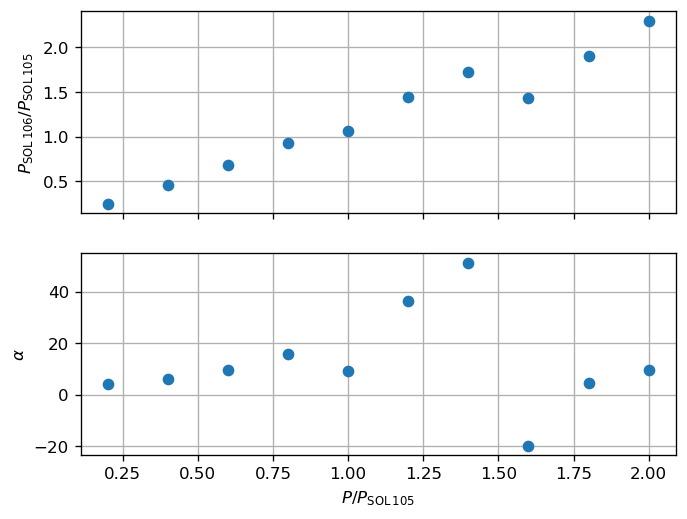

In [33]:
# Read nonlinear buckling loads and critical buckling factors from f06 file
f06_filepath = os.path.join(analysis_directory_path, input_name + ".f06")
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=f06_filepath,
                                                                                                            op2_object=sol_106_op2)

# Plot nonlinear buckling loads and critical buckling factors vs applied loads
_, axs = plt.subplots(nrows=2, ncols=1, sharex='all')  # figure with 2 subplots
axs[0].plot(applied_load_factors, nonlinear_buckling_loads/sol_105_buckling_load_magnitude, 'o')  # buckling loads vs applied loads
axs[1].plot(applied_load_factors, critical_buckling_factors, 'o')  # critical buckling factors vs applied loads

# Set plot appearance
axs[0].set_ylabel('$P_\mathrm{SOL\/106}/P_\mathrm{SOL\/105}$')
axs[0].grid(visible=True)
axs[1].set_ylabel('$\\alpha$')
axs[1].grid(visible=True)
axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
plt.show()

We observe that for the uCRM-9, the nonlinear buckling method is not able to predict the same buckling load as SOL 105 for the initial linear range of the structural response of the structure. Actually, for low applied load levels there appears to be a linear relationship between nonlinear buckling load and applied load. It is not clear why this happens, considering the linear structural response observed on the natural path. This sheds doubts on the reliability of the nonlinear buckling method for structures more complicated than a simple box beam, like the uCRM-9.

## Conclusions <a name="conclusions"></a>

***

In this notebook we have investigated the nonlinear structural response of the uCRM-9. We applied the 1g aerodynamic load and scaled it uniformly by a multiplicative factor for all our analyses, obtaining in this way a pseudo-aerodynamic load. We found the critical buckling load predicted by the linear buckling analysis and then we investigated the effect of the nonlinear analysis parameters on the results by applying twice the linear buckling load and looking at the changes of the load-displacement curve as the parameters were varied. We were able to identify a complementary path disconnected from the natural path of the structure. Finally we carried out a verification of SOL 106's nonlinear buckling method and we found out that the latter was not able to reproduce the linear buckling load for the initial linear range of the structural response, thus making it an unreliable method for the nonlinear buckling analysis of a wingbox structure like the one of the uCRM-9.